In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data = pd.read_csv('cpu_memory_usage_v1.csv', header=0)
data

,name,tags,time,pod_name,namespace,cpu_usage_nanocores,memory_working_set_bytes
0,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-wklkm,drive,96624523,1337585664
1,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-lpr67,drive,89770983,1361653760
2,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-sgr2x,drive,77112631,1285890048
3,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-2wdsh,drive,35692946,1254232064
4,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-chm2j,drive,93409866,1294434304
...,...,...,...,...,...,...,...
231630,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-wklkm,drive,12293800,1313955840
231631,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-sgr2x,drive,9217571,1338773504
231632,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-h8hqh,drive,13224852,1415725056
231633,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-b8k2z,drive,18092365,1453850624


In [32]:
data['time'] = pd.to_datetime(data['time'], unit='ns')
data = data.loc[data.pod_name == 'drive-az2-prd-69cbb999bc-lpr67']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')
data = data.loc[:,['time','cpu_usage_nanocores', 'memory_working_set_bytes']]

Text(0, 0.5, 'memory_working_set_bytes')

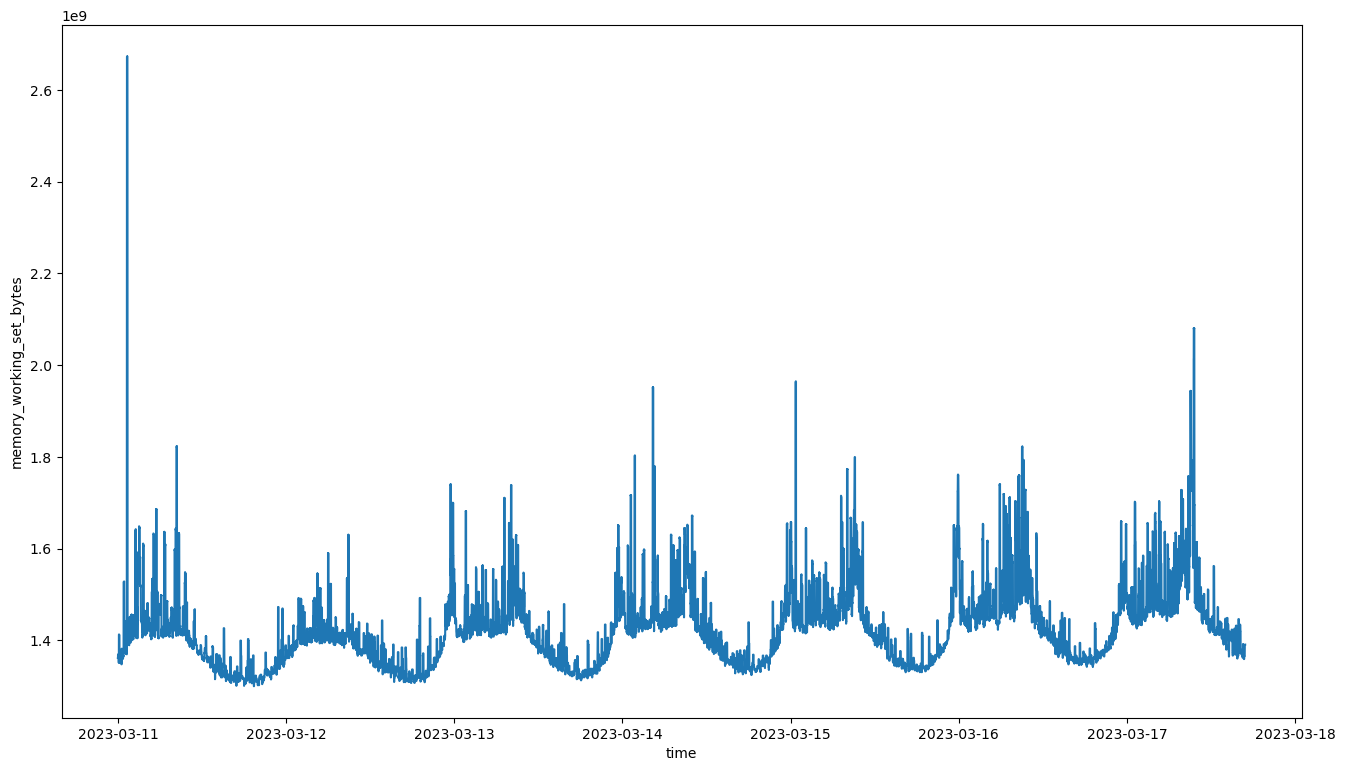

In [33]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=data['memory_working_set_bytes'], x=data['time'])
plt.xlabel('time')
plt.ylabel('memory_working_set_bytes')

In [34]:
from sklearn.preprocessing import MinMaxScaler

data.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['memory_working_set_bytes', 'cpu_usage_nanocores']
df_scaled = scaler.fit_transform(data[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,memory_working_set_bytes,cpu_usage_nanocores
0,0.044959,0.411576
1,0.044911,0.481051
2,0.049663,0.500366
3,0.049532,0.441449
4,0.050024,0.681631
...,...,...
19299,0.066024,0.031644
19300,0.066039,0.024549
19301,0.066039,0.036685
19302,0.066042,0.036176


In [35]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [36]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [37]:
from sklearn.model_selection import train_test_split

feature_cols = ['cpu_usage_nanocores']
label_cols = ['memory_working_set_bytes']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((15267, 20, 1), (3817, 20, 1))

In [38]:
x_train.shape

(15267, 20, 1)

In [46]:
train_feature.shape

(19084, 20, 1)

In [39]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 1), (200, 1))

In [40]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 1), (180, 1))

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import tensorflow as tf

In [42]:

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [43]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
939/955 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 1: val_loss improved from inf to 0.00192, saving model to model/tmp_checkpoint.h5
955/955 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 2/200
935/955 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss did not improve from 0.00192
955/955 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/200
945/955 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss improved from 0.00192 to 0.00191, saving model to model/tmp_checkpoint.h5
955/955 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/200
935/955 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss did not improve from 0.00191
955/955 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/200
951/955 [============================>.] - ETA

In [47]:
test_feature.shape

(180, 20, 1)

In [48]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 0s 1ms/step


(180, 1)

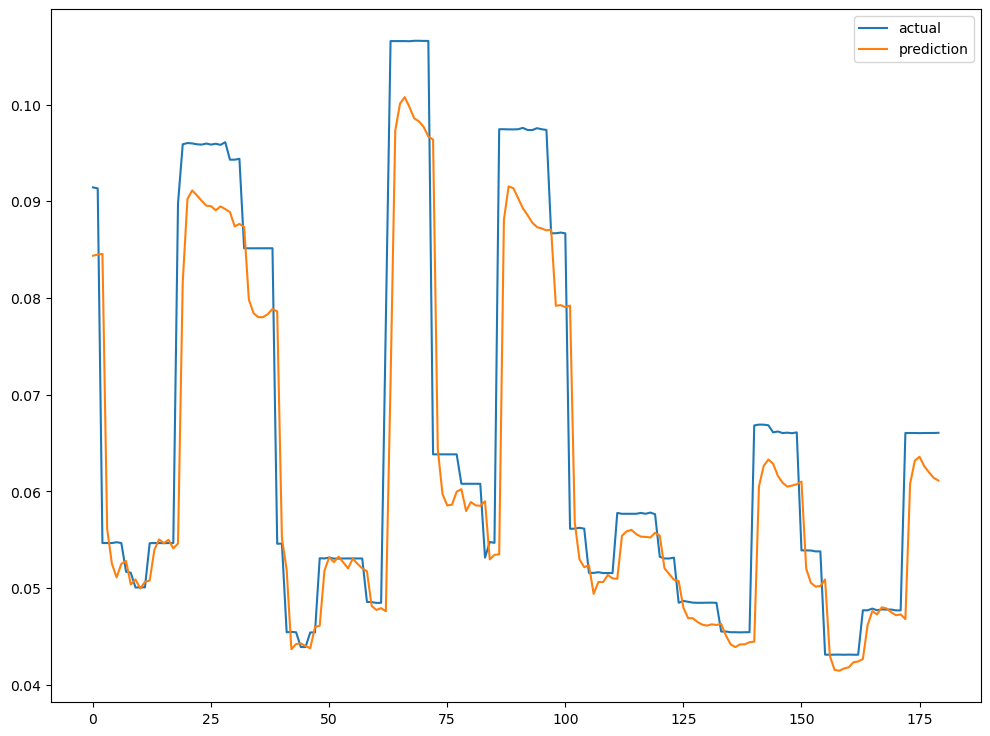

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()